#### Improt package

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from models import *
from tqdm import tqdm
from utils import *
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
torch.manual_seed(0)

In [15]:
def get_dataloaders(batch_size=128, num_workers=4):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    
    # print classes
    print("Classes in CIFAR10 dataset:", trainset.classes)
    classes = trainset.classes

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=100, shuffle=False, num_workers=num_workers)

    return trainloader, testloader, classes

In [16]:
trainloader, testloader, class_names = get_dataloaders()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 30
model_name = 'ResNet18'

Files already downloaded and verified
Classes in CIFAR10 dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Files already downloaded and verified


In [17]:
def train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=30, scheduler=None):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    pbar_epochs = tqdm(total=num_epochs, desc='Overall Progress', position=0)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0.0
        total_train = 0.0

        pbar_batches = tqdm(total=len(trainloader), desc=f'Epoch {epoch+1}/{num_epochs}', position=1, leave=False)

        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            if isinstance(criterion, nn.CrossEntropyLoss):
                loss = criterion(outputs, y)
            else:
                labels_onehot = F.one_hot(y, num_classes=10).to(torch.float)
                loss = criterion(outputs, labels_onehot)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += y.size(0)
            correct_train += (predicted == y).sum().item()
            pbar_batches.set_postfix(loss=loss.item())
            pbar_batches.update()

        pbar_batches.close()

        epoch_train_loss = running_loss / len(trainloader.dataset)
        epoch_train_acc = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Print training statistics
        # print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}')
        
        if scheduler is not None:
            scheduler.step(epoch_train_loss)
        
        # Valid process
        model.eval()  
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        with torch.no_grad():
            for X, y in testloader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                if isinstance(criterion, nn.CrossEntropyLoss):
                    loss = criterion(outputs, y)
                else:
                    labels_onehot = F.one_hot(y, num_classes=10).to(torch.float)
                    loss = criterion(outputs, labels_onehot)

                running_test_loss += loss.item() * X.size(0)
                _, predicted = torch.max(outputs, 1)
                total_test += y.size(0)
                correct_test += (predicted == y).sum().item()

        epoch_test_loss = running_test_loss / len(testloader.dataset)
        epoch_test_acc = correct_test / total_test
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_acc)

        # print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_acc:.4f}')
        pbar_epochs.set_postfix(train_loss=epoch_train_loss, train_acc=epoch_train_acc, test_loss=epoch_test_loss, test_acc=epoch_test_acc)
        pbar_epochs.update()
    pbar_epochs.close()
    print('Training completed')
    print(f'Training Accuracy: {train_accuracies[-1]}, Best Test Accuracy: {max(test_accuracies)}')
    return train_losses, train_accuracies, test_losses, test_accuracies




def plot_comparison(train_losses, train_accuracies, test_losses, test_accuracies, loss_kinds):

    num_functions = len(loss_kinds)
    
    plt.style.use('ggplot')
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    for i in range(num_functions):
        plt.plot(train_losses[i], label=f'{loss_kinds[i]}', linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    for i in range(num_functions):
        plt.plot(train_accuracies[i], label=f'{loss_kinds[i]}', linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.subplot(2, 2, 3)
    for i in range(num_functions):
        plt.plot(test_losses[i], label=f'{loss_kinds[i]}', linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss')
    plt.legend()

    plt.subplot(2, 2, 4)
    for i in range(num_functions):
        plt.plot(test_accuracies[i], label=f'{loss_kinds[i]}', linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Different loss function

Using ResNet18
Training with CrossEntropy


Overall Progress: 100%|██████████| 30/30 [07:38<00:00, 15.28s/it, test_acc=0.889, test_loss=0.389, train_acc=0.955, train_loss=0.128]


Training completed
Training Accuracy: 0.95518, Best Test Accuracy: 0.8945
Training with BCEWithLogits


Overall Progress:  10%|█         | 3/30 [2:07:18<19:05:43, 2546.07s/it, test_acc=0.737, test_loss=0.771, train_acc=0.716, train_loss=0.803]

Epoch 12/30:   1%|▏         | 5/391 [00:10<00:54,  7.10it/s, loss=0.0951]IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out

Epoch 12/30:   1%|▏         | 5/391 [00:40<00:54,  7.10it/s, loss=0.0781]IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
Overall Progress:  10%|█         | 3/30 [2:08:18<19:14:45, 2566.13s/it, test_acc=0.737, test_loss=0.771, train_acc=0.716, train_loss=0.803]

Epoch 12/30:   1%|▏         | 5/391 [01:10<00:54,  7.10it/s, loss=0.0781]IOStream.flush timed out
IOStream.flush timed out

IOStream.flush timed out
Epoch 12/30:   2%|▏         | 6/391 [01:40<2:15:19, 21.09s/it, loss=0.0781]IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
Overall Progress: 100%|██████████| 30/30 [09:34<00:00, 19.15s/it, test_acc=0.871, test_loss=0.0699, train_acc=0.921, train

Training completed
Training Accuracy: 0.92126, Best Test Accuracy: 0.8726
Training with MSE


Overall Progress: 100%|██████████| 30/30 [07:29<00:00, 14.99s/it, test_acc=0.81, test_loss=0.0294, train_acc=0.834, train_loss=0.0259] 


Training completed
Training Accuracy: 0.8341, Best Test Accuracy: 0.8101
Training with L1Loss


Overall Progress: 100%|██████████| 30/30 [07:27<00:00, 14.93s/it, test_acc=0.101, test_loss=0.102, train_acc=0.118, train_loss=0.102]


Training completed
Training Accuracy: 0.11802, Best Test Accuracy: 0.1842
Training with Huber


Overall Progress: 100%|██████████| 30/30 [07:29<00:00, 14.98s/it, test_acc=0.757, test_loss=0.0182, train_acc=0.772, train_loss=0.0174]


Training completed
Training Accuracy: 0.77154, Best Test Accuracy: 0.7572
Training with SoftMargin


Overall Progress: 100%|██████████| 30/30 [07:29<00:00, 14.99s/it, test_acc=0.838, test_loss=0.087, train_acc=0.918, train_loss=0.0443] 


Training completed
Training Accuracy: 0.91764, Best Test Accuracy: 0.8628


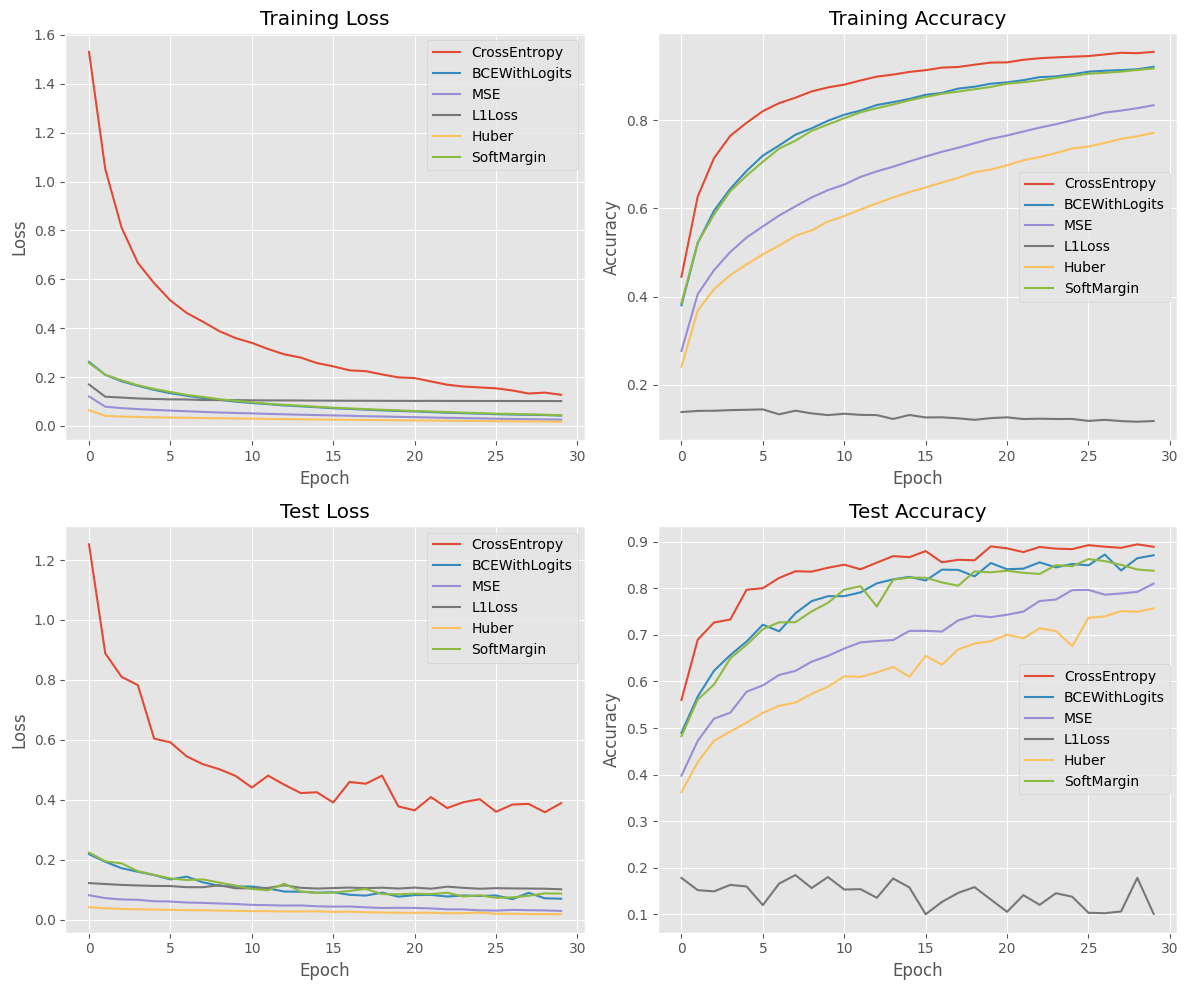

In [19]:
loss_functions = {
    'CrossEntropy': nn.CrossEntropyLoss(),
    'BCEWithLogits': nn.BCEWithLogitsLoss(),
    'MSE': nn.MSELoss(),
    'L1Loss': nn.L1Loss(),
    'Huber': nn.SmoothL1Loss(),
    'SoftMargin': nn.MultiLabelSoftMarginLoss()
}

all_train_losses = []
all_train_accuracies = []
all_test_losses = []
all_test_accuracies = []


print(f'Using {model_name}')
for loss_name, criterion in loss_functions.items():
    print(f'Training with {loss_name}')
    model = ResNet18()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, cooldown=5, min_lr=1e-6)
    model = model.to(device)
    train_losses, train_accuracies, test_losses, test_accuracies = train_model(
        model, trainloader, testloader, criterion, optimizer, num_epochs, scheduler)

    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_test_losses.append(test_losses)
    all_test_accuracies.append(test_accuracies)

loss_function_names = list(loss_functions.keys())
plot_comparison(all_train_losses, all_train_accuracies, all_test_losses, all_test_accuracies, loss_function_names)

### Different weight decay

Using ResNet18
Training with Weight Decay on 0.01


Overall Progress: 100%|██████████| 30/30 [07:42<00:00, 15.41s/it, test_acc=0.783, test_loss=0.645, train_acc=0.844, train_loss=0.479]


Training completed
Training Accuracy: 0.84436, Best Test Accuracy: 0.8064
Training with Weight Decay on 0.05


Overall Progress: 100%|██████████| 30/30 [07:41<00:00, 15.37s/it, test_acc=0.668, test_loss=1.02, train_acc=0.741, train_loss=0.864] 


Training completed
Training Accuracy: 0.74078, Best Test Accuracy: 0.6957
Training with Weight Decay on 0.001


Overall Progress: 100%|██████████| 30/30 [07:42<00:00, 15.40s/it, test_acc=0.892, test_loss=0.339, train_acc=0.946, train_loss=0.155]


Training completed
Training Accuracy: 0.94616, Best Test Accuracy: 0.9004
Training with Weight Decay on 0.005


Overall Progress: 100%|██████████| 30/30 [07:41<00:00, 15.37s/it, test_acc=0.815, test_loss=0.577, train_acc=0.885, train_loss=0.347]


Training completed
Training Accuracy: 0.885, Best Test Accuracy: 0.8523
Training with Weight Decay on 0.0001


Overall Progress: 100%|██████████| 30/30 [07:42<00:00, 15.42s/it, test_acc=0.893, test_loss=0.418, train_acc=0.963, train_loss=0.105]


Training completed
Training Accuracy: 0.96296, Best Test Accuracy: 0.8937
Training with Weight Decay on 0.0005


Overall Progress: 100%|██████████| 30/30 [07:41<00:00, 15.40s/it, test_acc=0.896, test_loss=0.359, train_acc=0.956, train_loss=0.126]


Training completed
Training Accuracy: 0.95616, Best Test Accuracy: 0.8958


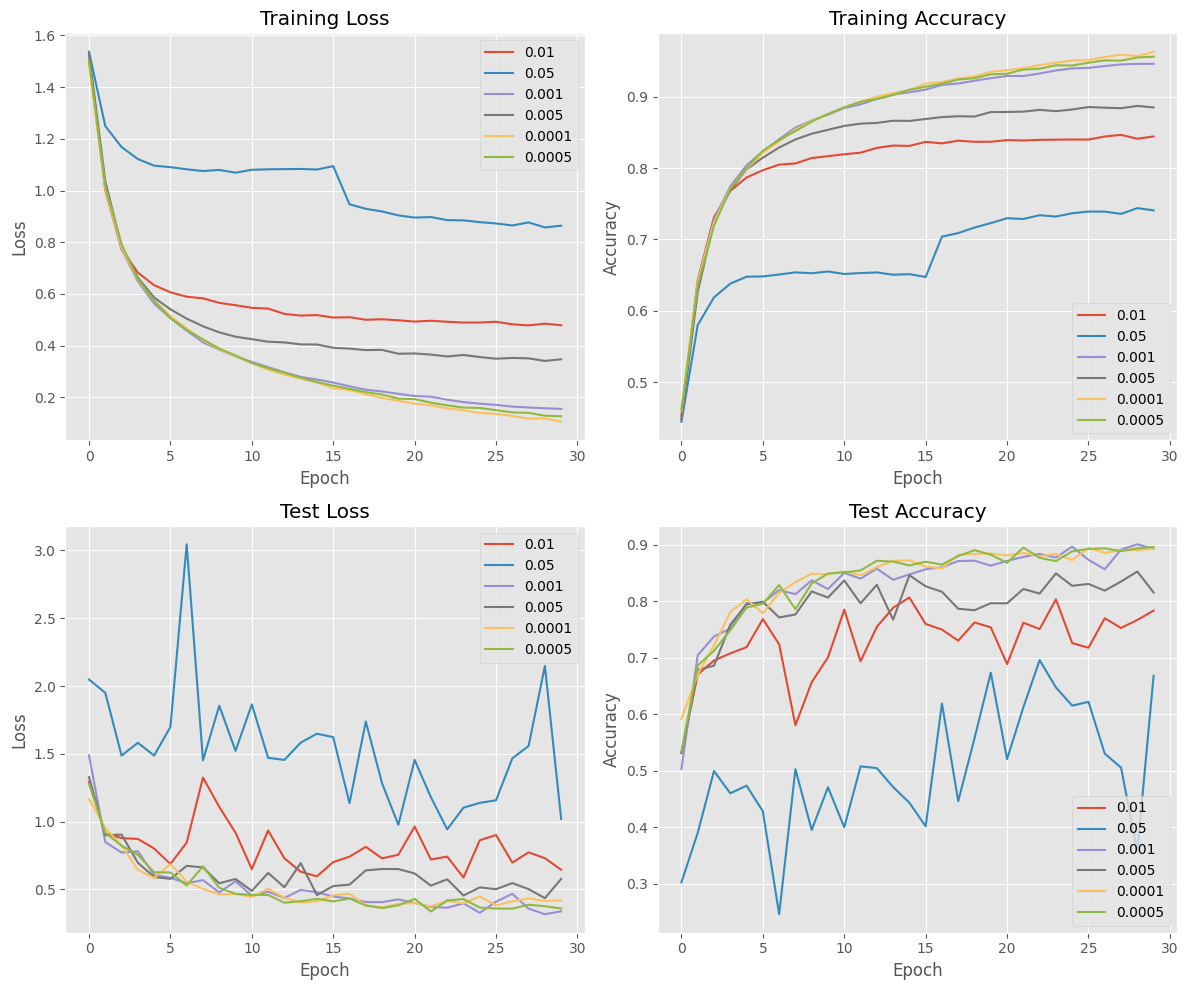

In [ ]:
l2_values = [0.01, 0.05, 0.001, 0.005, 1e-4, 5e-4]

all_train_losses = []
all_train_accuracies = []
all_test_losses = []
all_test_accuracies = []


print(f'Using {model_name}')
for l2_value in l2_values:
    print(f'Training with Weight Decay on {l2_value}')
    model = ResNet18()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=l2_value)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, cooldown=5, min_lr=1e-6)
    model = model.to(device)
    train_losses, train_accuracies, test_losses, test_accuracies = train_model(model, trainloader, testloader, criterion, optimizer, num_epochs, scheduler)

    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_test_losses.append(test_losses)
    all_test_accuracies.append(test_accuracies)

plot_comparison(all_train_losses, all_train_accuracies, all_test_losses, all_test_accuracies, l2_values)

### Different activation

Using ResNet18
Training with ReLU


Overall Progress: 100%|██████████| 30/30 [07:44<00:00, 15.48s/it, test_acc=0.893, test_loss=0.362, train_acc=0.956, train_loss=0.125]


Training completed
Training Accuracy: 0.9561, Best Test Accuracy: 0.8927
Training with ELU


Overall Progress: 100%|██████████| 30/30 [07:46<00:00, 15.57s/it, test_acc=0.878, test_loss=0.371, train_acc=0.901, train_loss=0.286]


Training completed
Training Accuracy: 0.9007, Best Test Accuracy: 0.8776
Training with Leaky ReLU


Overall Progress: 100%|██████████| 30/30 [07:47<00:00, 15.58s/it, test_acc=0.873, test_loss=0.461, train_acc=0.956, train_loss=0.126]


Training completed
Training Accuracy: 0.95568, Best Test Accuracy: 0.9
Training with GELU


Overall Progress: 100%|██████████| 30/30 [07:45<00:00, 15.52s/it, test_acc=0.9, test_loss=0.346, train_acc=0.959, train_loss=0.115]  


Training completed
Training Accuracy: 0.9589, Best Test Accuracy: 0.9016


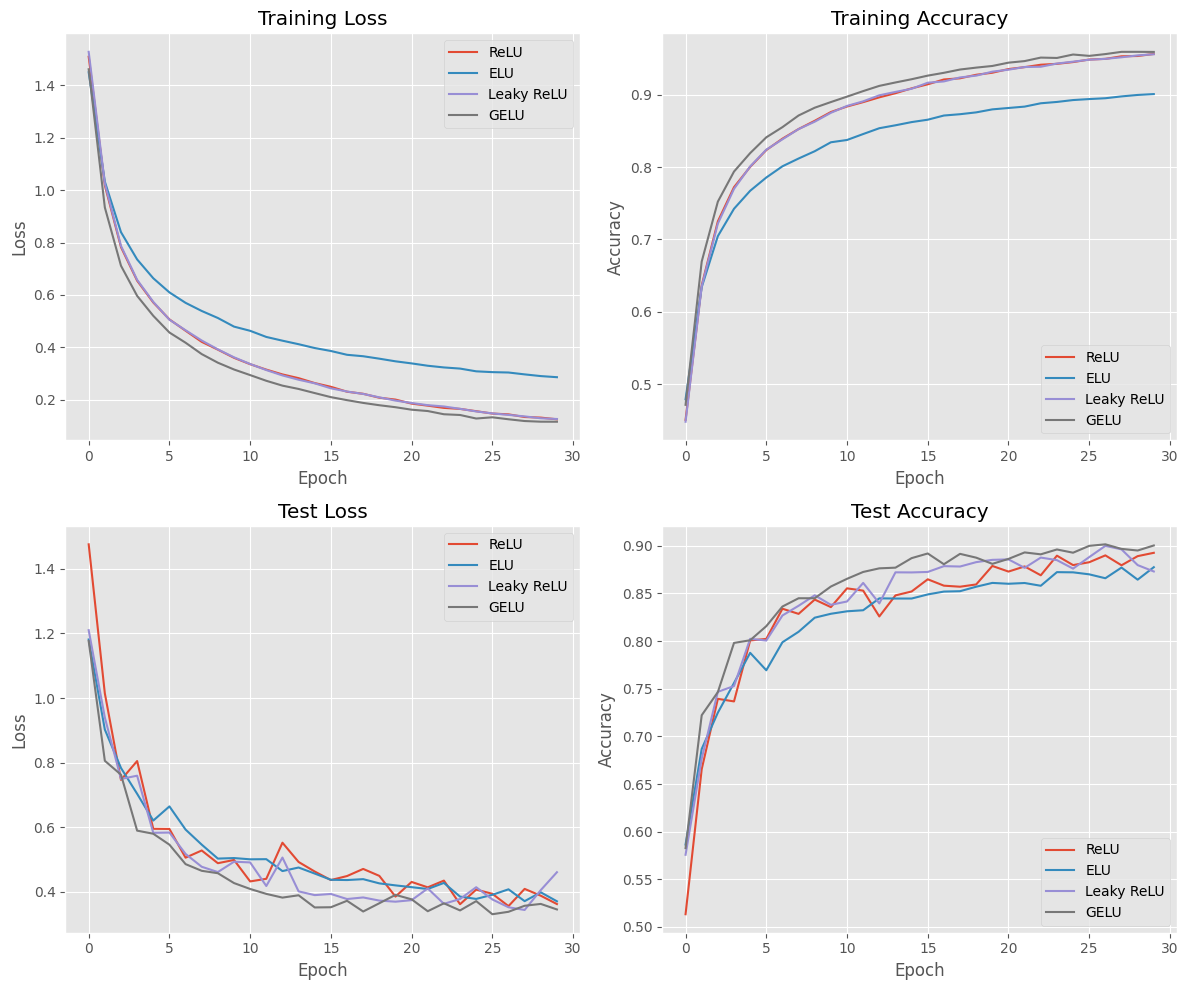

In [ ]:
activations = {
    'ReLU': ResNet18(),
    'ELU': ResNet18_ELU(),
    'Leaky ReLU': ResNet18_LeakyReLU(),
    'GELU': ResNet18_GELU()
}

all_train_losses = []
all_train_accuracies = []
all_test_losses = []
all_test_accuracies = []


print(f'Using {model_name}')
for act_name, model in activations.items():
    print(f'Training with {act_name}')
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, cooldown=5, min_lr=1e-6)
    model = model.to(device)
    train_losses, train_accuracies, test_losses, test_accuracies = train_model(
        model, trainloader, testloader, criterion, optimizer, num_epochs, scheduler)

    # Append results to lists
    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_test_losses.append(test_losses)
    all_test_accuracies.append(test_accuracies)

activation_names = list(activations.keys())
plot_comparison(all_train_losses, all_train_accuracies,
                   all_test_losses, all_test_accuracies, activation_names)

### Different optimizers

Using ResNet18 on CIFAR-10
Using SGD


Overall Progress: 100%|██████████| 30/30 [07:31<00:00, 15.04s/it, test_acc=0.896, test_loss=0.342, train_acc=0.955, train_loss=0.128]


Training completed
Training Accuracy: 0.955, Best Test Accuracy: 0.896
Using Nesterov


Overall Progress: 100%|██████████| 30/30 [07:32<00:00, 15.08s/it, test_acc=0.893, test_loss=0.354, train_acc=0.958, train_loss=0.121]


Training completed
Training Accuracy: 0.95802, Best Test Accuracy: 0.896
Using Adagrad


Overall Progress: 100%|██████████| 30/30 [07:29<00:00, 14.99s/it, test_acc=0.89, test_loss=0.404, train_acc=0.959, train_loss=0.116] 


Training completed
Training Accuracy: 0.95914, Best Test Accuracy: 0.9015
Using Adadelta


Overall Progress: 100%|██████████| 30/30 [07:40<00:00, 15.35s/it, test_acc=0.793, test_loss=0.627, train_acc=0.841, train_loss=0.452]


Training completed
Training Accuracy: 0.84134, Best Test Accuracy: 0.7968
Using Adam


Overall Progress: 100%|██████████| 30/30 [07:31<00:00, 15.05s/it, test_acc=0.547, test_loss=1.53, train_acc=0.724, train_loss=0.796] 


Training completed
Training Accuracy: 0.7241, Best Test Accuracy: 0.6889
Using Adamax


Overall Progress: 100%|██████████| 30/30 [07:37<00:00, 15.25s/it, test_acc=0.801, test_loss=0.602, train_acc=0.842, train_loss=0.461]


Training completed
Training Accuracy: 0.84234, Best Test Accuracy: 0.8268
Using RMSprop


Overall Progress: 100%|██████████| 30/30 [07:31<00:00, 15.06s/it, test_acc=0.184, test_loss=4.96, train_acc=0.42, train_loss=1.56] 


Training completed
Training Accuracy: 0.42018, Best Test Accuracy: 0.3049


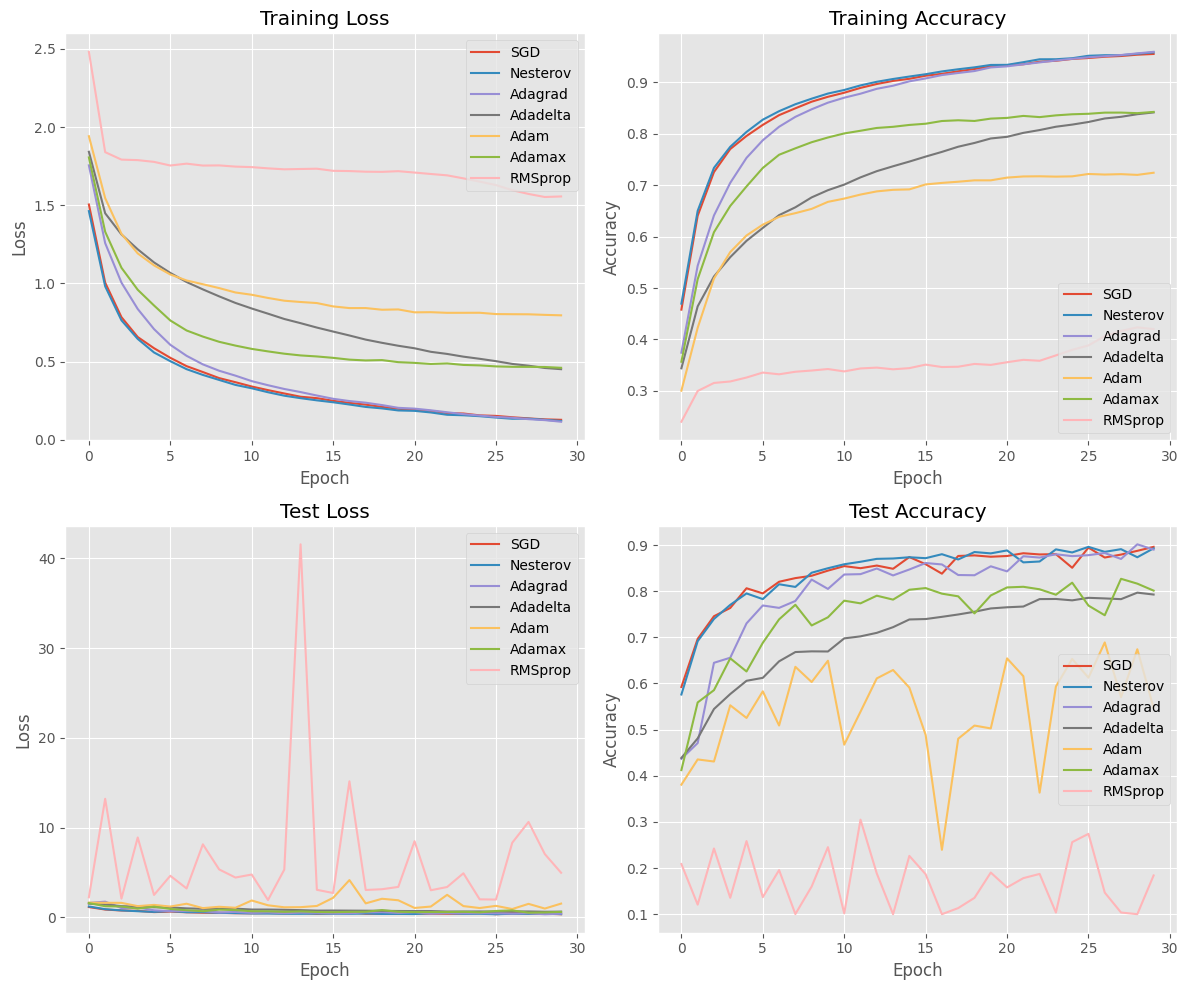

In [ ]:
optimizers = [
    'SGD',
    'Nesterov',
    'Adagrad',
    'Adadelta',
    'Adam',
    'Adamax',
    'RMSprop'
]

all_train_losses = []
all_train_accuracies = []
all_test_losses = []
all_test_accuracies = []


print(f'Using {model_name} on CIFAR-10')
for opt in optimizers:
    print(f'Using {opt}')
    model = ResNet18()
    model = model.to(device
    if opt == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01,
        momentum=0.9, weight_decay=5e-4)
    elif opt == 'Nesterov':
        optimizer = optim.SGD(model.parameters(), lr=0.01,
        momentum=0.9, weight_decay=5e-4, nesterov=True)
    elif opt == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=0.01,
        weight_decay=5e-4)
    elif opt == 'Adadelta':
        optimizer = optim.Adadelta(model.parameters(), lr=0.01,
        weight_decay=5e-4)
    elif opt == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.01,
        weight_decay=5e-4)
    elif opt == 'Adamax':
        optimizer = optim.Adamax(model.parameters(), lr=0.01,
        weight_decay=5e-4)
    elif opt == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.01,
                                  alpha=0.99, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, cooldown=5, min_lr=1e-6)
    train_losses, train_accuracies, test_losses, test_accuracies = train_model(
        model, trainloader, testloader, criterion, optimizer, num_epochs, scheduler)

    # Append results to lists
    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_test_losses.append(test_losses)
    all_test_accuracies.append(test_accuracies)

plot_comparison(all_train_losses, all_train_accuracies, all_test_losses, all_test_accuracies, optimizers)

### More epochs on Relu and GELU

Overall Progress:  63%|██████▎   | 19/30 [06:45<03:54, 21.32s/it, test_acc=0.891, test_loss=0.351, train_acc=0.937, train_loss=0.177]

Using ResNet18
Training with ReLU


Overall Progress: 100%|██████████| 50/50 [12:32<00:00, 15.06s/it, test_acc=0.896, test_loss=0.375, train_acc=0.974, train_loss=0.0765]


Training completed
Training Accuracy: 0.97376, Best Test Accuracy: 0.9114
Training with GELU


Overall Progress: 100%|██████████| 50/50 [12:32<00:00, 15.04s/it, test_acc=0.904, test_loss=0.33, train_acc=0.974, train_loss=0.0756] 


Training completed
Training Accuracy: 0.97416, Best Test Accuracy: 0.9124


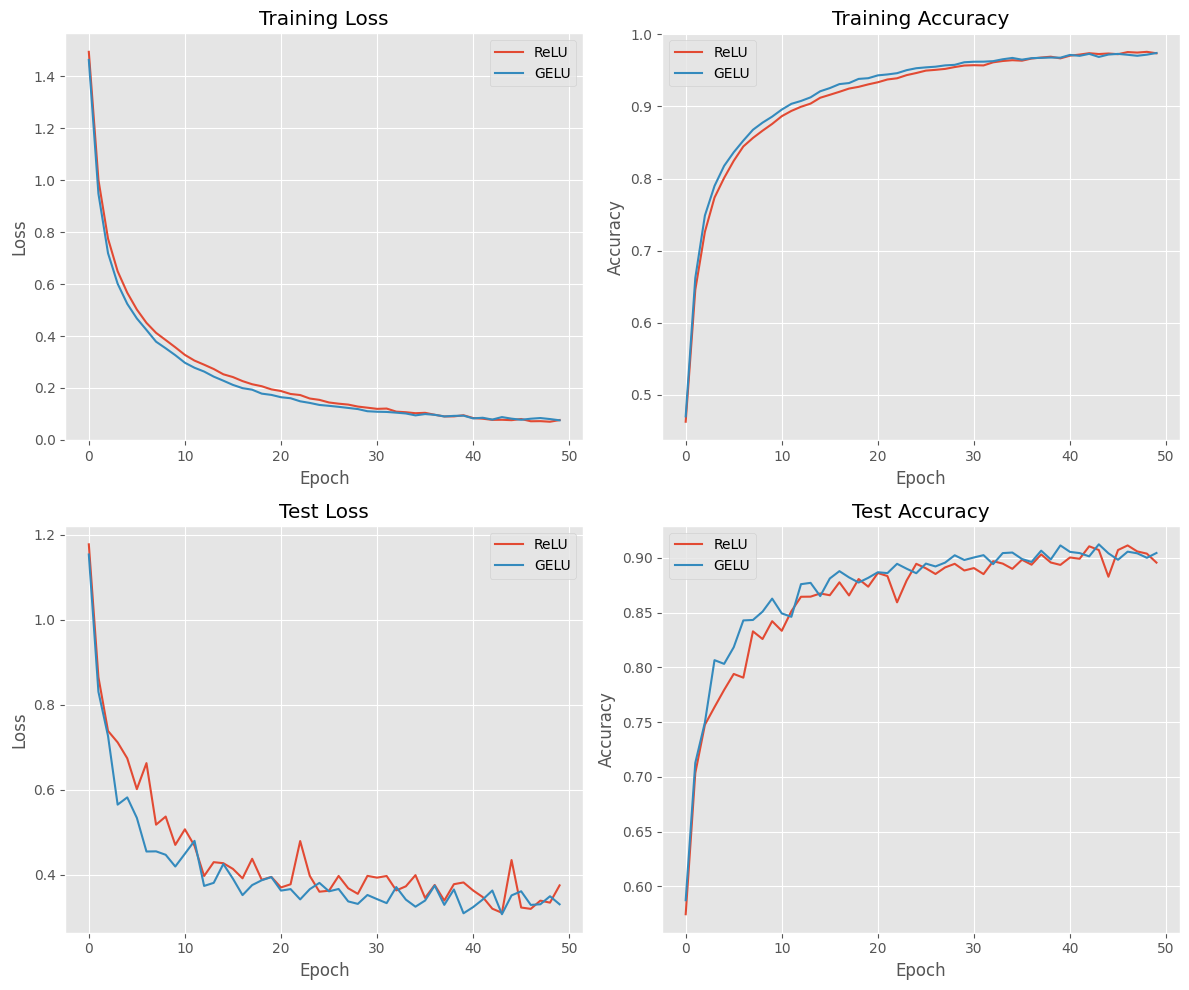

In [ ]:
activations = {
    'ReLU': ResNet18(),
    'GELU': ResNet18_GELU()
}

all_train_losses = []
all_train_accuracies = []
all_test_losses = []
all_test_accuracies = []


print(f'Using {model_name}')
for act_name, model in activations.items():
    print(f'Training with {act_name}')
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, cooldown=5, min_lr=1e-6)
    model = model.to(device)
    train_losses, train_accuracies, test_losses, test_accuracies = train_model(
        model, trainloader, testloader, criterion, optimizer, num_epochs, scheduler)

    # Append results to lists
    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_test_losses.append(test_losses)
    all_test_accuracies.append(test_accuracies)

activation_names = list(activations.keys())
plot_comparison(all_train_losses, all_train_accuracies,
                   all_test_losses, all_test_accuracies, activation_names)